In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.colors import NoNorm
import scipy.optimize as optimize
from PIL import Image
%matplotlib inline

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path='/content/drive/My Drive/DIP/Assignment02/'
img1=cv.imread(path+'input/IIScMainBuilding_LowContrast.png',cv.IMREAD_GRAYSCALE)
img2=cv.imread(path+'input/LowLight_2.png',cv.IMREAD_GRAYSCALE)
img3=cv.imread(path+'input/LowLight_3.png',cv.IMREAD_GRAYSCALE)
img4=cv.imread(path+'input/Hazy.png',cv.IMREAD_GRAYSCALE)
img5=cv.imread(path+'input/StoneFace.png',cv.IMREAD_GRAYSCALE)

bee=cv.imread(path+'input/Bee.jpg')
bee=cv.cvtColor(bee,cv.COLOR_BGR2RGB)
noisy=cv.imread(path+'input/noisy.tif',cv.IMREAD_GRAYSCALE)
clean_char=cv.imread(path+'input/characters.tif',cv.IMREAD_GRAYSCALE)

car=cv.imread(path+'input/crime_car.png')
crime1=cv.imread(path+'input/crime_sample1.png')
crime2=cv.imread(path+'input/crime_sample2.png')
crime3=cv.imread(path+'input/crime_sample3.png')
crime4=cv.imread(path+'input/crime_sample4.png')

#Q1

In [4]:
def FSCS(img):
    lmax=np.amax(img)
    lmin=np.amin(img)
    nimg=np.divide(np.subtract(img,lmin),lmax-lmin)*255
    freq,bin=np.histogram(nimg,bins=256)
    return nimg,freq

def NLCSL(img):
    limg=25*np.log(img+1)
    np.where(limg>255,255,limg)
    np.where(limg<0,0,limg)
    freq,bin=np.histogram(limg,bins=256,range=(0,256))
    return limg.astype('uint8'),freq

def NLCSE(img):
    eimg=np.exp(img)
    np.where(eimg>255,255,eimg)
    np.where(eimg<0,0,eimg)
    freq,bin=np.histogram(eimg,bins=256,range=(0,256))
    return eimg.astype('uint8'),freq

def HistEqua(img):
    freq=np.bincount(img.flatten(),minlength=256)
    s=np.sum(freq)
    cdf=np.divide(freq,s)
    cdf=np.cumsum(cdf)
    cdf=np.round(cdf*255).astype('uint8')
    eimg=img
    '''for i in range(0, img.shape[0]):
        for j in range(0,img.shape[1]):
            eimg[i,j] = cdf[img[i, j]]'''
    vfun=lambda intensity : cdf[intensity]
    vfun=np.vectorize(vfun)
    eimg=vfun(img)
    #eimg=np.reshape(np.asarray(eimg),img.shape)
    efreq=np.bincount(img.flatten(),minlength=256)
    return eimg,efreq

def CLAHE(img,clip_limit):
    s1,s2=img.shape
    h=np.floor(s1/8).astype('int')
    w=np.floor(s2/8).astype('int')
    nimg=img
    for i in range(0,8):
        for j in range(0,8):
            block=img[i*h:i*h+h,j*w:j*w+w]
            f,b=np.histogram(block,bins=256,range=(0,256))
            clip=0
            for k in range(256):
              if f[k]>clip_limit:
                clip+=(f[k]-clip_limit)
                f[k]=clip_limit
            func=lambda x:np.round(x+clip/255) if (x+clip/255<clip_limit) else min(x,clip_limit)
            func=np.vectorize(func)
            func(block)
            nimg[i*h:i*h+h,j*w:j*w+w],freq=HistEqua(block)
    freq,bin=np.histogram(nimg,bins=256,range=(0,256))
    return nimg,freq

def CLAHE_overlapped(img,clip_limit=300):
    s1,s2=img.shape
    h=np.floor(s1*4/25).astype('int')
    w=np.floor(s2*4/25).astype('int')
    nimg=img
    for i in range(0,8):
        for j in range(0,8):
            a=i*h-i*(int)(h/4)
            b=j*w-j*(int)(w/4)
            block=img[a:a+h,b:b+w]
            f,_=np.histogram(block,bins=256,range=(0,256))
            clip=0
            for k in range(256):
              if f[k]>clip_limit:
                clip+=(f[k]-clip_limit)
                f[k]=clip_limit
            func=lambda x:np.round(x+clip/255) if (x+clip/255<clip_limit) else min(x,clip_limit)
            func=np.vectorize(func)
            func(block)
            a=int(a)
            b=int(b)
            nimg[a:a+h,b:b+w],freq=HistEqua(block)
    freq,_=np.histogram(nimg,bins=256,range=(0,256))
    return nimg,freq



In [ ]:
def test_Q1(method='FSCS',clip_limit=1000):
  img=[img1,img2,img3,img4,img5]
  for i in range(0,5):
      nimg,freq=img[i],0
      if method=='FSCS':
        nimg,freq=FSCS(img[i])
      elif method=='NLCSL':
        nimg,freq=NLCSL(img[i])
      elif method=='NLCSE':
        nimg,freq=NLCSL(img[i])
      elif method=='HistEqua':
        nimg,freq=HistEqua(img[i])
      elif method=='CLAHE':
        nimg,freq=CLAHE(img[i],clip_limit)
      elif method=='CLAHE_overlapped':
        nimg,freq=CLAHE_overlapped(img[i],clip_limit)

      plt.figure(figsize=(40,40))
      plt.subplot(2,1,1)
      plt.imshow(nimg,cmap='gray')
      plt.subplot(2,1,2)
      plt.plot(range(0,256),freq,color='red',linewidth=10)
      #plt.imsave(path+'output/FCFS'+i+'.png',nimg)
      plt.savefig(path+f'output/{method}{i}.png')
test_Q1('HistEqu')

# Q-2 Image Upsampling

In [ ]:
def upsample(img,k,method):
    nimg=np.zeros(np.multiply(img.shape,k))
    h=nimg.shape[0]
    w=nimg.shape[1]
    if(method=='nn'):
        for i in range(0,h):
            for j in range(0,w):
                nimg[i,j]=img[i//k,j//k]
    elif(method=='bl'):       
        for i in range(0,h):
            for j in range(0,w):
                x,y=i//k,j//k
                a=i/k-x
                b=j/k-y
                if ((y+1)<img.shape[1]) and ((x+1)<img.shape[0]):
                    nimg[i,j]=(1-a)*(1-b)*img[x,y]+(1-a)*b*img[x,y+1]+a*(1-b)*img[x+1,y]+a*b*img[x+1,y+1]
                else:
                    nimg[i,j]=img[x,y]
    return nimg

def subsample(img,k):
    nimg=np.zeros(np.divide(img.shape,k).astype('int'))
    h=nimg.shape[0]
    w=nimg.shape[1]
    for i in range(0,h):
            for j in range(0,w):
                nimg[i,j]=img[k*i,k*j]
    return nimg

def test_Q2(inter,k):
  nbee=cv.cvtColor(bee,cv.COLOR_BGR2GRAY)
  img=[img5,nbee]
  for i in range(len(img)):
    temp=subsample(img[i],k)
    zoom=upsample(temp,k,inter)
    mse=np.sum(np.square(np.subtract(img[i][0:k*temp.shape[0],0:k*temp.shape[1]],zoom)))/(zoom.shape[0]*zoom.shape[1])
    plt.figure(figsize=(40,40))
    plt.imshow(zoom,cmap='gray')
    plt.savefig(path+f'output/Upsameple_{inter}{i}.png')
    print(f'Mse error for image {i} is {mse}')

test_Q2('bl',2)

#  Q-3 Image rotation

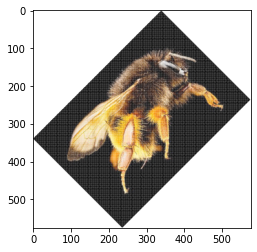

In [ ]:
def rotation(img,theta,interpol):
  cosine=np.cos(np.radians(theta))
  sine=np.sin(np.radians(theta))
  h=img.shape[0]
  w=img.shape[1]
  center_h=round((h+1)/2-1)
  center_w=round((w+1)/2-1)

  nh=round(abs(h*cosine)+abs(w*sine))
  nw=round(abs(w*cosine)+abs(h*sine))
  center_nh=round((nh+1)/2-1)
  center_nw=round((nw+1)/2-1)

  output=np.ones((nh,nw,img.shape[2]))*255
  
  for i in range(h):
    for j in range(w):
      x=w-1-j-center_w
      y=h-1-i-center_h
      x=-x

      a=x*cosine+y*sine
      b=-x*sine+y*cosine
      nx=np.floor(a).astype('int')
      ny=np.floor(b).astype('int')

      a=a-nx
      b=b-ny

      nx=center_nw+nx
      ny=center_nh-ny

      if (nx>=0) and (nx<nw-1) and (ny>=0) and (ny<nh-1):
        if interpol=='bl' and i+1<h and j+1<w:
          output[ny,nx,:]=np.floor((1-a)*(1-b)*img[i,j,:]+(1-a)*b*img[i,j+1,:]+a*(1-b)*img[i+1,j,:]+a*b*img[i+1,j+1,:]).astype('uint8')
        elif interpol=='nn':
          output[ny,nx,:]=img[i,j,:]
  
  return output.astype('uint8')
def test_Q3(angle,method):
  for i in angle:
    nimg=rotation(bee,i,method)
    plt.imshow(nimg)
    plt.savefig(path+f'output/rotate{i}.png')



# **Q4** High boost filter


mse = 39.81280210586804  k = 1


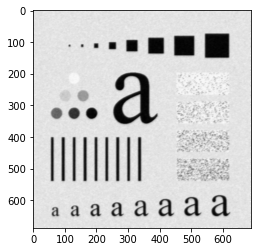

In [12]:
def avg_filter(img,s):
  mask=np.ones((s,s))
  h=img.shape[0]
  w=img.shape[1]
  l=np.floor(s/2).astype('int')
  out=img
  for i in range(h):
    for j in range(w):
      if (i>=l and j>=l and i<h-l and j<w-l):
        out[i,j]=np.sum(np.multiply(img[i-l:i+s-l,j-l:j+s-l],mask))//(s*s)
  return out

def sharp(k,img,mask):
  img=img+k*mask
  return np.sum(np.square(np.subtract(img,clean_char)))/(img.shape[0]*img.shape[1])

def high_boost(img,f,k):
  hi=img
  mask=hi-avg_filter(img,f)#f=filter size
  img=hi+k*mask
  return img

def test_Q4(que,fltr):
  if que=='a':
    smooth=avg_filter(noisy,fltr)
    plt.title(f'{fltr}x{fltr}')
    plt.imshow(smooth,cmap='gray')
    plt.imsave(path+f'output/smoothnoisy_{fltr}.png',smooth,cmap='gray')
  elif que=='b':
    c=0
    mse=-1
    nimg=clean_char
    for k in range(1,20,4):
      sharpen=high_boost(noisy,fltr,k)
      t=np.sum(np.square(np.subtract(clean_char,sharpen)))/(sharpen.shape[0]*sharpen.shape[1])
      if mse==-1 or mse>t:
        mse=t
        nimg=sharpen
        c=k
        continue
    plt.imshow(nimg,cmap='gray')
    print(f'mse = {mse}  k = {c}')
    plt.imsave(path+f'output/sharpen_{c}.png',nimg,cmap='gray')
  elif que=='c':
    nimg=noisy+1*noisy
    plt.imshow(nimg,cmap='gray')
    plt.imsave(path+f'output/sharpen_wo_clena.png',nimg,cmap='gray')

test_Q4('b',5)

#*Q5* template matching

In [ ]:
def template_match(img,pat):
  seed=(0,0)
  prev=-1
  for i in range(0,img.shape[0]-pat.shape[0]):
    for j in range(0,img.shape[1]-pat.shape[1]):
      temp=np.sum(np.square(np.subtract(img[i:i+pat.shape[0],j:j+pat.shape[1]],pat)))
      if prev==-1 or temp<prev:
        prev=temp
        seed=(j,i)
  return seed

def ob_detection(img,pat):
  #load_img()
  gimg=img
  gimg=cv.cvtColor(gimg,cv.COLOR_BGR2GRAY)
  pat=cv.cvtColor(pat,cv.COLOR_BGR2GRAY)
  gimg,efreq=HistEqua(gimg)
  pat,_=HistEqua(pat)
  #gimg,efreq=CLAHE_overlapped(gimg,100)
  '''
  res=cv.matchTemplate(eimg,pat,cv.TM_SQDIFF)
  min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
  top_left = min_loc  #Change to max_loc for all except for TM_SQDIFF
  bottom_right = (top_left[0] + pat.shape[1], top_left[1] + pat.shape[0])
  '''
  seed=template_match(gimg,pat)
  bottom_right=(seed[0]+pat.shape[1],seed[1]+pat.shape[0])
  img=cv.cvtColor(img,cv.COLOR_BGR2RGB)
  cv.rectangle(img, seed, bottom_right,(255,255,255),2)
  #plt.imshow(img)
  return img

In [ ]:
#for only template matching comment HistEqua line
def test_Q5b():
  img=[crime1,crime2,crime3,crime4]
  for i in range(len(img)):
    ob=ob_detection(img[i],car)
    plt.imsave(path+f'output/template_crime{i}.png',ob)
    plt.figure(figsize=(20,20))
    plt.subplot(4,1,i+1)
    plt.imshow(ob)

In [ ]:
def test_Q5():
  img=[crime1,crime2,crime3,crime4]
  for i in range(len(img)):
    ob=ob_detection(img[i],car)
    plt.imsave(path+f'output/crime{i}.png',ob)
    plt.figure(figsize=(20,20))
    plt.subplot(4,1,i+1)
    plt.imshow(ob)

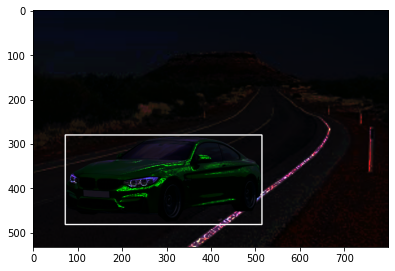

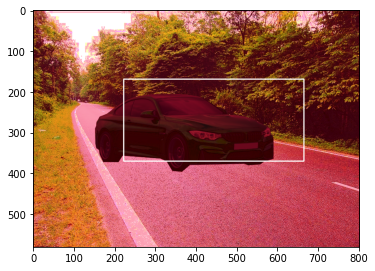

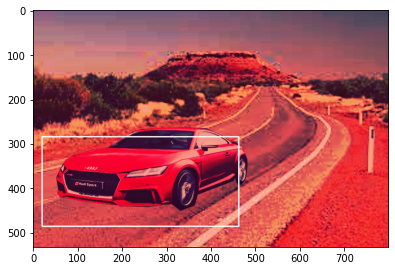

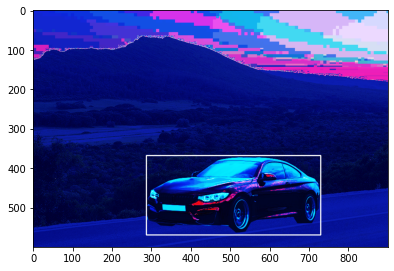

In [ ]:
def run_program():
  #test_Q1('FSCS')
  #test_Q1('NLCSL')
  #test_Q1('NLCSE')
  #test_Q1('HistEqua')
  #test_Q1('CLAHE')
  #test_Q1('CLAHE_overlapped')
  #test_Q2('nn',2)#'nn' 'bl'
  #test_Q3([30,75,-45],'bl')
  #test_Q4('b',5)
  #test_Q5()
  test_Q5b()#without HistEqualiation
run_program()

In [ ]:
def hist_match(asli, referensi):

    asli_shape = asli.shape
    
    asli = asli.ravel()
    referensi = referensi.ravel()

    o_values, bin_idx, o_counts = np.unique(asli, return_inverse=True,return_counts=True)
    b_values, b_counts = np.unique(referensi, return_counts=True)

    o_quantiles = np.cumsum(o_counts).astype(np.float64)
    o_quantiles /= o_quantiles[-1]
    b_quantiles = np.cumsum(b_counts).astype(np.float64)
    b_quantiles /= b_quantiles[-1]

    interp_t_values = np.interp(o_quantiles, b_quantiles, b_values)

    return interp_t_values[bin_idx].reshape(asli_shape)